# Problem Set 3: questions 1.3 and 1.4

## Finite Sample Properties of Linear GMM

This Python notebook answers questions 1.3-1.4 on Problem Set 3a.

We consider the OLS model
$$ y = \alpha + X\beta + u$$
where
$$E[X^Tu] = E[u] = 0.$$

In [1]:
# Set up environment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as iid
from numpy.linalg import inv
from scipy.optimize import minimize
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import probplot

## Step 1: DGP

We first describe the process that generates $(y,X,u)$.

To do so, we impose 
$$Cov(x,u)=E[X^Tu] - E[X]E[u] = 0$$
and assume $\sigma_X=2$ and $u \sim N(0,1).$

In [2]:
# Step 1: The DGP
def dgp(true_beta, N):
    
    # Define Correlations between inputs (random variables) 
    sigma_xu = 0 # corr(x,u) = E(xu)-E(x)*E(u)
    sigma_x  = 2 # Assumed as truth
    sigma_u  = 1 # Assume u ~ N(0,1), E(u)=0 given. V
    
    # 
    cov_XU = np.array(
        [[sigma_x**2, sigma_xu],
        [sigma_xu,    sigma_u**2]])
    
    # Assume E(x) = 0.2
    XU = iid.multivariate_normal(mean=[.2, 0],
                                   cov=cov_XU).rvs(size = N)
    
    
    X = XU[:, [0]] # Extract all rows in col 0 
    u = XU[:, [1]] # Extract all rows in col 1
    
    # Calculate y
    y = true_beta[0][0] + X*(true_beta[0][1]) + u
    X = np.c_[np.ones(shape = (N,1)), X] # add intercept
    
    return (y, X)

In [3]:
# Step 2: create data
N = 500
beta_true = np.array((0.5, 0.75)).reshape(1,-1) # 1x2 array
data = dgp(beta_true, N) # Tuple
y, X = dgp(beta_true, N) # alternatively, unpack

In [4]:
# View the dataset
data_df = pd.DataFrame(np.concatenate(data, axis=1), columns = ["y", "const.", "x1"])
data_df.head()

,y,const.,x1
0,-0.293953,1.0,0.065407
1,0.359378,1.0,-0.479795
2,-0.887537,1.0,-0.336323
3,-0.024480,1.0,-0.384872
4,-0.082694,1.0,-0.764569


## Step 3: set up the moment condition and $E[gg']=\Omega^{-1}$

We set up $g_j(b)$ followed by $g_N(b) = \frac{1}{n} \sum_{i=1}{n}g_j(b).$

In [5]:
def gj(betas, data):
    # unpack my inputs
    beta = betas
    beta = np.array(beta).reshape(1,-1)
    y, X = data
    # set up moments (separately)
    moment1 = X*(y-X@beta.T)
    
    # stack the moments next to each other
    moments = np.concatenate([moment1], axis=1)
    
    return moments

In [6]:
gj(beta_true, data)[:5] # these are pretty small, bc the betas are right!

array([[-0.8430078 , -0.05513821],
       [ 0.21922414, -0.10518269],
       [-1.13529458,  0.38182554],
       [-0.23582648,  0.09076297],
       [-0.00926804,  0.00708605]])

In [7]:
beta_false = np.array((1,2)).reshape(1,2)
gj(beta_false, data)[:5] # these are much larger!

array([[-1.42476595, -0.09318899],
       [ 0.31896814, -0.15303938],
       [-1.21489098,  0.40859563],
       [-0.25473667,  0.09804097],
       [ 0.44644266, -0.34133602]])

In [8]:
def gN(beta, data):
    # get individual moments
    e = gj(beta, data)
    # take mean
    
    if type(beta) is tuple:
        dim1 = (len(beta))
    else:
        dim1 = 1
    
    # Check to see more obs. than moments.
    assert e.shape[0] > e.shape[1], "Need more observations than moments!"
    
    gN = e.mean(axis=0)
    return gN

In [9]:
# test: we want these = 0!
print(f"using true beta: Eg_j =\n {gN(beta_true, data)}\n")
print(f"using other beta: Eg_j =\n {gN(beta_false, data)}")

using true beta: Eg_j =
 [-0.04750427  0.05289739]

using other beta: Eg_j =
 [-0.94593826 -4.8190387 ]


In [10]:
def invOmega(beta, data):
    #print(beta)
    e = gj(beta, data)
    # recenter
    e = e - e.mean(axis=0)

    N = e.shape[0]
    var = e.T@e/N
    return np.linalg.inv(var)

## Step 4: Set up the criterion function

In [11]:
# putting it all together, we get the objective function we want to minimize:
def J(beta,invomega,data):
    
    g = gN(beta,data) # Sample moments
    N = data[0].shape[0]

    return (N*g.T)@invomega@g # .squeeze() # Scale by sample size

In [12]:
print(f'J at the true beta = {J(beta_true,invOmega(beta_true, data),data)}')
print(f'J at some wrong beta = {J(beta_false,invOmega(beta_false, data),data)}')

J at the true beta = 1.7159415217902925
J at some wrong beta = 238.7912285022252


## Step 5: Use the two_step_gmm algorithm to find $\hat{\beta}_{GMM}.$

In [13]:
def two_step_gmm(beta_true, data):
    
    # First step uses identity weighting matrix
    W1 = np.eye(gj(beta_true,data).shape[1])
    
    opt_output = minimize(lambda b: J(b, W1, data), x0 = [0.5, 0.75], method = 'Nelder-Mead') 
    b1 = opt_output.x
    
    # Construct 2nd step weighting matrix using
    # first step estimate of beta
    W2 = invOmega(b1,data)

    return minimize(lambda b: J(b,W2,data), x0 = b1, method = 'Nelder-Mead')

In [14]:
soltn = two_step_gmm(beta_true, data).x

## Setp 6: Simulations

### Step 6.1: Monte Carlo Experiment

we draw repeated samples of data, each generating a corresponding estimate of beta. Then the empirical distribution of these samples tells us about the *finite* sample performance of our estimator.

We will generate a sample of estimates of $b$ by drawing repeated samples of size $N$:



In [15]:
N = 1000 # Sample size

D = 1000 # Monte Carlo draws

b0_draws = []
b1_draws = []
J_draws = []
for d in range(D):
    
    output = two_step_gmm(beta_true, dgp(beta_true, N))
    
    J_draws.append(output.fun)
    soltn = output.x

    beta_0 = soltn[0]
    beta_1 = soltn[1]
    b0_draws.append(beta_0)
    b1_draws.append(beta_1)


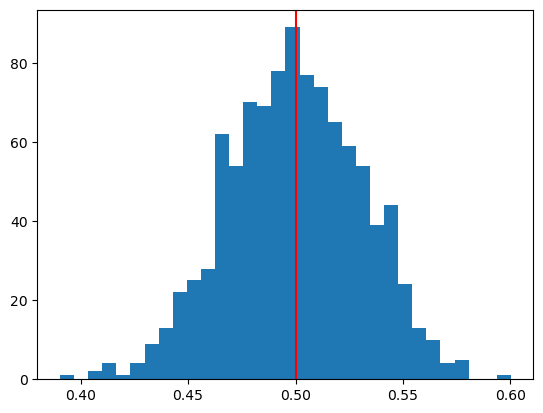

In [16]:
# Plot beta_0 and true beta_0
_ = plt.hist(b0_draws,bins=int(np.ceil(np.sqrt(D))))
_ = plt.axvline(beta_true[0][0],color='r')

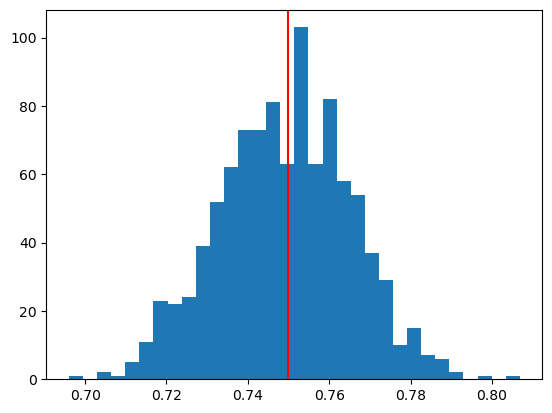

In [17]:
# Plot beta_1 and true beta_1
_ = plt.hist(b1_draws,bins=int(np.ceil(np.sqrt(D))))
_ = plt.axvline(beta_true[0][1],color='r')

## Step 6.2: Distribution of Monte Carlo draws vs. asymptotic distribution

The betas in the plots above seem to follow a normal distribution. To test this, we display a PP-Plot of the betas from our Monte Carlo experiment against betas drawn from the true distribution. 

The true distribution of beta (a random vector) follows a multivariate normal distribution centered at the true values and spread according to the covariance matrix estimator
$$V_{\beta} = (Q^T\Omega^{-1}Q)^{-1}$$
which we estimate using our data and true parameter values as follows:
$$\hat{V}_{\beta} = (\hat{Q}^T\hat{\Omega}^{-1}\hat{Q})^{-1} .$$
Thus the asymptotic standard errors of our parameters are given by
$$Se(\beta) = \sqrt{\frac{\hat{V}_{\beta}}{n}} .$$

In [18]:
def Q(data):

    y,X = data
    
    # Edgj/db'
    return X.T@X/N 

In [19]:
# Generate betas for each N given asymptotic variance defined above

# Limiting SE of b
Q = Q(data)
W = invOmega(beta_true, data)
V_beta = lambda N: inv(Q.T@W@Q) # 2x2 matrix

# We know that the random vector beta has correlated elements hence we could
# generate a multivariate normal probability density as follows
limiting_b  = iid.multivariate_normal(mean=[beta_true[0][0], beta_true[0][1]],
                                      cov=V_beta(N))

# But we also know that the marginal density of each beta is simply normal
limiting_b0 = iid.norm(loc = beta_true[0][0], scale = np.sqrt(V_beta(N)[0][0]/N) ) # se = sqrt(v/n)
limiting_b1 = iid.norm(loc = beta_true[0][1], scale = np.sqrt(V_beta(N)[1][1]/N) ) 


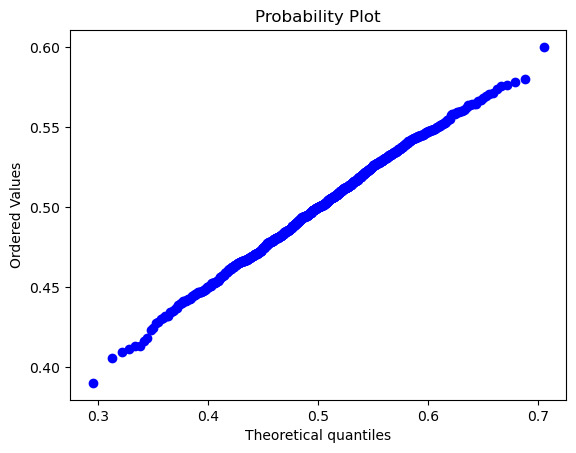

In [20]:
# beta_0
_ = probplot(b0_draws,dist=limiting_b0,fit=False,plot=plt)

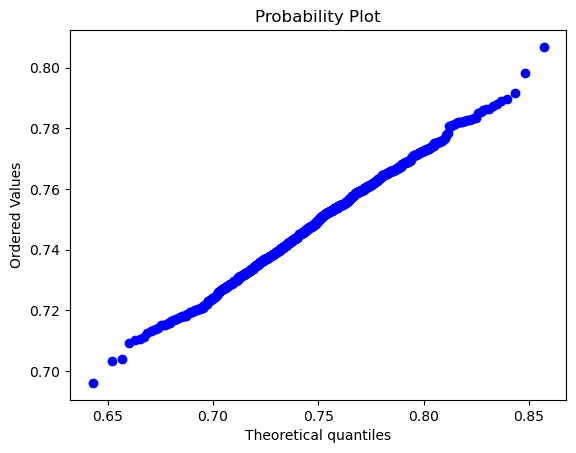

In [21]:
# beta_1
_ = probplot(b1_draws,dist=limiting_b1,fit=False,plot=plt)

Finally, consider the a $p$-$p$ plot for the $J$ statistic. This plot is not feasible for the model in question 1.2.b. 

Recall that $J$ should be distributed $\chi^2_{\ell-k}$ where $\ell$ is the number of moments and $k$ is the number of parameters. In this example, the model is just-identified ($\ell = k$). That is, we are certain to find parameters that satisfy the moment conditions, and the criterion function need not be minimized because $\exists \beta : J(\beta)=0$. In particular,

$$ \hat{\beta}_{MM} = argmin_{\beta} J_n(\beta).$$
In other words,
$$J(\hat{\beta}_{MM}) = 0$$
such that 
$$\hat{\beta}_{GMM} = \hat{\beta}_{MM} .$$